In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
trainset = torchvision.datasets.CIFAR10(root='./datasets',
                                       train=True,
                                       download=True,
                                       transform=transforms.ToTensor())

Files already downloaded and verified


In [3]:
trainloader = torch.utils.data.DataLoader(trainset, 
                                         batch_size=64, #default is 1  #64?
                                         shuffle=True,
                                         num_workers=2) #use 2 subprocesses for data loading

In [4]:
testset = torchvision.datasets.CIFAR10(root='./datasets',
                                       train=False, #this will download test set
                                       download=True,
                                       transform=transforms.ToTensor())

Files already downloaded and verified


In [5]:
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=1000, #default is 1 #1000?
                                         shuffle=False, #false for testset
                                         num_workers=2)

In [6]:
labels = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
import matplotlib.pyplot as plt
import numpy as np


In [8]:
images_batch, labels_batch = iter(trainloader).next()

In [9]:
images_batch.shape

torch.Size([64, 3, 32, 32])

In [10]:
#we need to reshape data
#use a torchvision utility to make a grid of images in this batch
img = torchvision.utils.make_grid(images_batch)
#it places images side by side

In [11]:
img.shape 
#8 images placed side_by_side, 2 pixel padding between images and the edges of the grid
#number of channels, height, width

torch.Size([3, 274, 274])

In [12]:
#we need to make the channel the last one for matplotlib, matplotlib requires the channels to be the 3rd dimension
np.transpose(img, (1,2,0)).shape
#height, width, number of channels

torch.Size([274, 274, 3])

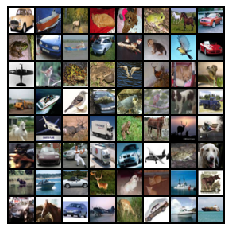

In [13]:
plt.imshow(np.transpose(img, (1,2,0)))
plt.axis('off')
plt.show()

In [14]:
import torch.nn as nn
import torch.nn.functional as F #contains logSoftmax function
import torch.optim as optim


In [15]:
in_size = 3 #input is the 3 channels of the image
hid1_size=32 #6 for LeNet-5   #16 CNN  #HW32
hid2_size=64 #16 for LeNet-5  #32 CNN  #HW64
out_size = len(labels)
k_conv_size =5 #5*5 convolution kernel

In [16]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(  #groups of sequential layers
            nn.Conv2d(in_size, hid1_size, k_conv_size , stride =1, padding =0),
            #nn.Conv2d(in_size, hid1_size, k_conv_size), 
            nn.BatchNorm2d(hid1_size), #normalize the outputs of this layer for one batch so they have 0 mean and unit variance
            #only need the number of channels, the batch size, height and width of the input can be inferred
            nn.ReLU(), #pass the output to the activation function
            nn.MaxPool2d(kernel_size=2)) #max pool layer with a 2*2 kernel
        
        self.layer2 = nn.Sequential(  
            nn.Conv2d(hid1_size, hid2_size, k_conv_size, stride =1, padding =0), 
            nn.BatchNorm2d(hid2_size), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2)) 
        
        
        #number of features to represent one image: 32*5*5
        #the size of each image after passing through 2 convolutional and 2 pooling layers is 5*5
        self.fc1 = nn.Linear(hid2_size * k_conv_size * k_conv_size, 200) #120 for LeNet-5 #200HW
        self.fc2 = nn.Linear(200,100) #(120,84) #(200,100)HW
        self.fc3 = nn.Linear(100, out_size) #output_size= classification categories  #84 #100 HW
        
        
    def forward(self, x): #x are input
        out = self.layer1(x)
        out = self.layer2(out)
        #take next out for in_size = 1
        out = out.reshape(out.size(0), -1) #reshape the output so each image is represented as a 1D vector to feed into the linear layer
        out = torch.sigmoid(self.fc1(out))   #torch.sigmoid #F.relu HW
        out = torch.sigmoid(self.fc2(out)) #then output of first layer passes to the second layer
                                      #torch.sigmoid #F.relu HW
        out = self.fc3 (out) # no activation function needed for this layerr: Last layer is a linear layer with no activation 
        
        #mathematically equivalent to log(softmax(x))
        #performing those operations separately is numerically unstable
        # this single function is a better alternative
        return F.log_softmax(out, dim=-1) #dimension along which softmax will be computed, 
                                        #here we allow the function to infer the right dimension
        
        
        

In [17]:
#ready to instantiate and train out convolution network
model = ConvNet()

In [18]:
learning_rate = 0.001
#momentum = 0.9
criterion = nn.CrossEntropyLoss() #measure of distance between prob distribution 
optimizer = torch.optim.Adam(model.parameters(), 
                            lr=learning_rate)
#optimizer = optim.SGD(model.parameters(),
                      #lr=learning_rate,
                       # momentum = momentum)

In [19]:
#train_accuracy.clear() 
#loss_values.clear()

In [20]:
total_step = len(trainloader)
num_epochs = 40 
loss_values = list()
training_accuracy = list()
loss_per_epoch = list()
loss_per_epoch = list()
training_accuracy_per_epoch = list()
loss_save = list()
training_acc_save = list()


In [21]:
for epoch in range(num_epochs):
    
   
   
    total_train=0
    correct_train = 0
    
    for i, (images, labels) in enumerate(trainloader,0): #it gives us one batch of images at a time
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
       
        
        _,pred_train=torch.max(outputs.data, 1)
        

    
        total_train += labels.nelement()
        correct_train += pred_train.eq(labels).sum().item()
        train_accuracy = 100 * correct_train / total_train
        
        loss_values.append(loss.item())
        training_accuracy.append(train_accuracy)
        
        loss_save.append(loss.item())
        training_acc_save.append(train_accuracy)
        
        if (i+1) % 200 == 0:
            
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} '
                  .format(epoch+1, num_epochs, i+1, total_step, loss.item() ))
         
    
    loss_per_epoch.append(sum(loss_values)/len(loss_values))
    loss_values.clear()
    #print ('loss_per_epoch', loss_per_epoch)
    training_accuracy_per_epoch.append(sum(training_accuracy)/len(training_accuracy))
    training_accuracy.clear()
    #print ('training accuracy per epoch',training_accuracy_per_epoch )
                

Epoch [1/40], Step [200/782], Loss: 1.6268 
Epoch [1/40], Step [400/782], Loss: 1.2470 
Epoch [1/40], Step [600/782], Loss: 1.2546 
Epoch [2/40], Step [200/782], Loss: 1.0453 
Epoch [2/40], Step [400/782], Loss: 0.9845 
Epoch [2/40], Step [600/782], Loss: 1.2625 
Epoch [3/40], Step [200/782], Loss: 0.8687 
Epoch [3/40], Step [400/782], Loss: 1.1354 
Epoch [3/40], Step [600/782], Loss: 0.9455 
Epoch [4/40], Step [200/782], Loss: 0.8385 
Epoch [4/40], Step [400/782], Loss: 0.6170 
Epoch [4/40], Step [600/782], Loss: 0.7137 
Epoch [5/40], Step [200/782], Loss: 0.7491 
Epoch [5/40], Step [400/782], Loss: 0.7504 
Epoch [5/40], Step [600/782], Loss: 0.6627 
Epoch [6/40], Step [200/782], Loss: 0.7047 
Epoch [6/40], Step [400/782], Loss: 0.5039 
Epoch [6/40], Step [600/782], Loss: 0.7907 
Epoch [7/40], Step [200/782], Loss: 0.6088 
Epoch [7/40], Step [400/782], Loss: 0.6320 
Epoch [7/40], Step [600/782], Loss: 0.8332 
Epoch [8/40], Step [200/782], Loss: 0.4775 
Epoch [8/40], Step [400/782], Lo

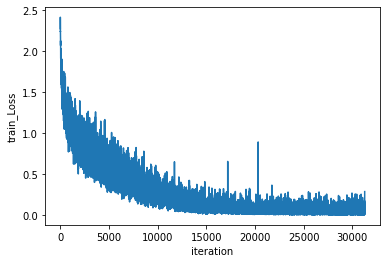

In [22]:
r=len(loss_save)
x = (range (1,r+1))

plt.plot(x,loss_save)
plt.xlabel('iteration')
plt.ylabel('train_Loss')
plt.show()

In [23]:

print ('loss_per_epoch', loss_per_epoch)
print ('training accuracy per epoch',training_accuracy_per_epoch)

loss_per_epoch [1.444494944094392, 1.0522211675753679, 0.889954179296713, 0.7918499826317857, 0.7065664090387657, 0.6373472858191757, 0.5733339267466074, 0.5140769572742759, 0.4533703816135216, 0.40333529157787945, 0.35559933209586936, 0.3048280757254042, 0.26774204767230525, 0.22855476277601688, 0.19746840972443827, 0.16723410920490084, 0.1463489424451576, 0.13018091987161076, 0.11113812616857155, 0.10189288049159795, 0.09006925360859393, 0.0868833624814992, 0.08033466395800529, 0.06898275923098215, 0.07190903164970372, 0.06311412387803826, 0.06203775070702938, 0.06346727027486333, 0.054707970827474924, 0.059097276278831004, 0.04581122049053088, 0.053287179738371285, 0.05123673491162079, 0.04609691890363303, 0.053524780769587096, 0.036690019410076165, 0.041133442953469525, 0.04539105524082699, 0.04243968387016469, 0.03921320890773164]
training accuracy per epoch [37.91779700431725, 61.185187130402895, 67.61836563836353, 71.68383791383508, 74.94282532179625, 77.79287553800248, 80.24517

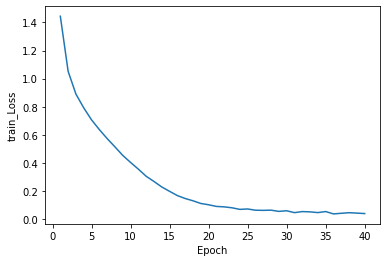

In [24]:
x = (range (1,num_epochs+1))

plt.plot(x,loss_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('train_Loss')
#plt.ylim (2.3, 2.4)
plt.show()



In [25]:
loss_values.clear()


Text(0, 0.5, 'train_accuracy')

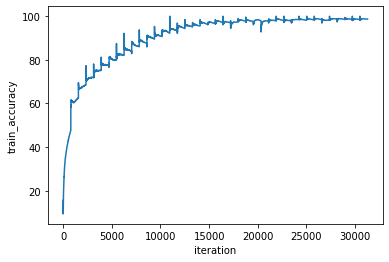

In [26]:
r= len (training_acc_save)
y = (range (1,r+1))
plt.plot(y, training_acc_save)
plt.xlabel('iteration')
plt.ylabel('train_accuracy')


(0, 40)

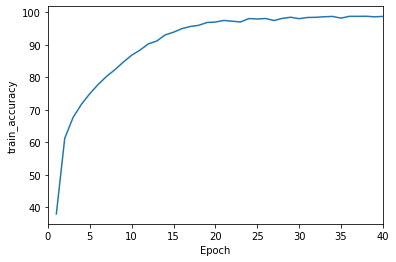

In [27]:
#y = np.linspace(0, 1/total_step, num_epochs)
#y = (range (1,len(training_accuracy_per_epoch)))
y = (range (1,num_epochs+1))
plt.plot(y, training_accuracy_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('train_accuracy')
plt.xlim(0,len(training_accuracy_per_epoch))

In [28]:
training_accuracy.clear()  

In [29]:
testing_accuracy = list()

In [30]:
#set our model to evaluation or prediction mode
model.eval()
#we don't want grad to be calculated during prediction
with torch.no_grad():
    correct = 0
    total = 0
    
    
    total_test=0
    correct_test = 0
    
    for images, labels in testloader:
        outputs = model(images)
        
        
        
        _,predicted = torch.max(outputs.data, 1)
        #total number of test instances
        total += labels.size(0)
        #calculate total number of correct predictions
        
        correct += (predicted == labels).sum().item()
        
        
        total_test += labels.nelement()
        correct_test += predicted.eq(labels).sum().item()
        test_accuracy = 100 * correct_test / total_test
        
        
        testing_accuracy.append(test_accuracy)
        
        
        
    print ('Accuracy of the model on the 10000 test images: {}%'
          .format(100 *correct /total))
        



Accuracy of the model on the 10000 test images: 73.74%


(70, 80)

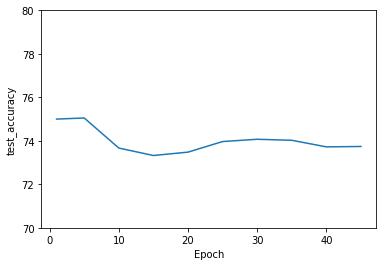

In [36]:
#y = range (1,len(testing_accuracy))
#y=[0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
y=[1,5,10,15,20,25,30,35,40,45]
plt.plot(y, testing_accuracy)
plt.xlabel('Epoch')
plt.ylabel('test_accuracy')
plt.ylim(70,80)



In [32]:
#loss_values_test = list()

In [33]:
#testing_accuracy = list()

In [34]:
#testing_accuracy.clear()

In [35]:
print(testing_accuracy)

[75.0, 75.05, 73.66666666666667, 73.325, 73.48, 73.96666666666667, 74.07142857142857, 74.025, 73.72222222222223, 73.74]
